In [1]:
# REDACT
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy

from scipy.stats import gaussian_kde

data  = np.loadtxt("./03.csv",delimiter=',', encoding='utf-8-sig', dtype =int)
data[:,0]-=1

class night():
    def __init__(self,i):
        self.i=i
        indices = np.where(data[:,0]==i)[0]
        self.upper = np.max(data[indices,1:3])
        self.lower = np.min(data[indices,1:3])
        self.rolls = data[indices,3]

        self.r = (self.rolls-self.lower) / (self.upper-self.lower)

        self.n = len(indices)
        self.N = np.linspace(0,self.n,self.n)
        
nights = [night(i) for i in range(len(np.unique(data[:,0]))) if night(i).n>10]
all_rolls = np.concatenate([a.r for a in nights])

# Is the Raffle Rigged? Practical Stats for a Toy Problem

Over the Christmas break, I was presented with an interesting question. A family member, frequenting a local sports club raffle, had become suspicious that the ticket numbers were being drawn in unusual "lumps" instead a truly "random" uniform pattern. As the ranking statistician in the family, I was pitted against the problem of answering a simple question: 
>_Is something funny going on?_

You've almost definitely run across something similar in your own life: an ostensibly random process that, by coincidence or conspiracy, seems determined to have a personal vendetta against you. The human mind is pattern-seeking, and famously terrible at reckoning with true randomness. Our brains expect _smoothness_, and raise false alarms whenever this expectation is upset, with superstition and suspicion to follow soon after.  This is where statistics makes itself useful. The statistician has two jobs: firstly to tease out true patterns in systems too large for an individual human to comprehend, and secondly to properly recognise the threat of coincidence in systems so small that the human mind _over_-comprehends them. The trained statistician's lot is to answer life’s most difficult questions with the most confident "maybe"s of all time. This is an unimpressive trick and rarely gets you invited to parties, but it's important all the same.

In this article, I vastly over-complicate an investigation this raffle fairness. Unlike the other articles on this blog, this is aimed at a reader _untrained_ in advanced statistics. Over the next four sections, I'll step through ways of attacking the problem in increasing levels of complexity, starting from "common-sense" approaches that you could imagine yourself creating (e.g. **[bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))**) and steadily advancing to the high-level tools you'd see applied in astrophysics (e.g. the **[Kolmogorov–Smirnov Test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)**). At each step, you'll see how the organizing principle for is the framing of our original question in a new and specific way, and how this question evolves over time as we ask more specific things about the world.

----


**The Setup**  
Tickets begin selling each night at some lower limit, and are purchased contiguously until the raffle begins. Tickets are cheap and players can buy as many as they like, so the number sold can easily enter the thousands. When the raffle arrives, ticket numbers are drawn randomly between the lowest and highest numbers sold, ignoring and duplicates, continuing until every prize has been awarded (typically a dozen and a half or so). If all goes well, these ticket draws should be completely random and completely uniform: any two numbers should be equally likely to come up.

**The Data**  
The data we have to play with a real-world draw numbers for $188$ nights, totalling $2,976$ tickets, as well as the upper and lower bounds of the tickets sold that night. The number of sold tickets on any given night ranges from a few dozen to 10s of thousands, while the number of draws ranges from a handful to a few dozen.

**The Concern**  
Consider the following: a night where $13$ numbers are drawn between $11$ and $11,680$. Instead of a nice uniformity, the numbers seem to be weirdly clustered around $\approx 6,000$, with the remainders falling into two other tight clumps (See the graph below). This seems unusual, but _how_ unusual? Would you have to play a hundred games to get that kind of clustering? A thousand? This is the first step we take in our analysis, properly defining our question:

> _How close are the ticket draws to a uniform distribution?_

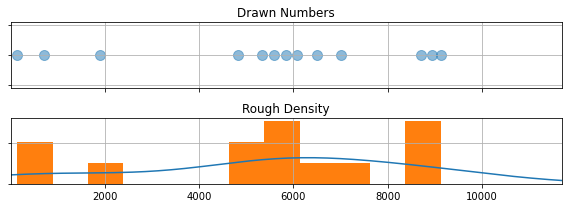

In [2]:
# REDACT
a = nights[23]
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,3), sharex=True)

ax1.scatter(a.rolls,np.zeros_like(a.rolls), s= 100, alpha = 0.5)

ax2.plot(np.linspace(a.lower,a.upper,128),gaussian_kde(a.rolls)(np.linspace(a.lower,a.upper,128)))
ax2.hist(a.rolls,density=True, bins=12)

ax1.grid(), ax2.grid()
ax1.set_yticklabels([]), ax2.set_yticklabels([])

ax1.set_xlim(a.lower,a.upper)

ax1.set_title("Drawn Numbers")
ax2.set_title("Rough Density")
plt.tight_layout()
plt.show()

## Part One: Rules of Thumb and Common Sense Diagnostics

In this section, I'm going to forego any hard statistical tools and attack this with the sort of common-sense approach that someone untrained in statistics might use. These approaches might be simple, but they still have real use even in complex problems: they act as a sort of "quick glance" you might use to satisfy your curiosity or direct your focus. Specifically, I'm going to call on two new tricks:
1. Sorting the tickets in order
2. "Bootstrapping"

**Sorting**  
The first thing we need to do is organize our data in a way we can make sense of.  The "number line" approach I used above is cluttered and hard to read, and the histogram below is coarse and patchy. We have too few tickets to build up a clear picture of the way the tickets are distributed, so trying to "bin" them gives a choppy graph where the smoothed curve we overlaid on top doing a lot of guesswork.

A natural next step is to instead sort the draws in order from smallest to largest, and then scatter-plot them. This un-clutters the number line, but also avoids "binning" the tickets into number ranges. There's another advantage: if the tickets were perfectly uniform, they would sort into a clean, straight line. We've got a concrete way to ask our question now:
>_How much do the sorted draws differ from a straight line?_

If the draws show a large deviation from a straight line, this suggests that something is going funny with the numbers.

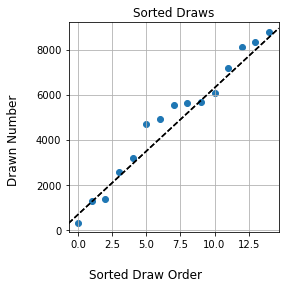

In [3]:
# REDACT
a = nights[5]

#----------------------------------
def BS(a,ntrials=200):
    out = np.zeros([ntrials,a.n], dtype='int32')

    for i in range(ntrials):
        out[i,:] = np.sort(np.random.choice(a.rolls, a.n, replace=True))

    norm = out.mean(axis=0)
    std = out.std(axis=0)
    
    return(np.arange(a.n), norm, std, out)

A, norm, std, wires= BS(a)

#-------------------------------------
fig, ax1 = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)

ax1.set_title("Sorted Draws")
ax1.scatter(A,np.sort(a.rolls))
ax1.axline((0,norm.min()), (a.n-1,norm.max()), c='k', ls='--')

for ax in [ax1]:
    ax.axline((0,norm.min()), (a.n-1,norm.max()), c='k', ls='--')
    ax.grid()

fig.supylabel("Drawn Number")
fig.supxlabel("Sorted Draw Order")
fig.tight_layout()

plt.show()

**Boostrapping**  
I skipped an important detail here. I used the phrase "large deviation", but what exactly constitutes "large"? Yes, the sorted draws have some wobble, but is it a _lot_ of wobble? To answer this, we can invoke the nifty trick of [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)), a technique that asks "using _only_ what we know from our measurements, what sort of similar results _could_ I have gotten"? In our case, the trick goes like this:

1. Take the total data set (the list of $15$ raffle draws)
2. Randomly _subsample_ these, re-selecting another $15$ randomly from this list, allowing for double ups
3. Repeat the sorting and plotting we did for the original draws (Left panel)
4. Repeat steps 1-3 many times (Middle Panel), noting how wide a spread you get in the results (Right Panel)

Doing this a few hundred times (middle panel), we build up an envelope of how the sorted curve _might_ look if we "smudge" it to account account for coincidence (right panel). This tamps down the effect of outliers and makes things fuzzy enough that only large, significant features really stand out. For our example night of raffle draws, we can see that the wobbles fall well within the bounds of random chance.

Bootstrapping, applied properly, is a nearly universal tool for getting a rough idea of how important the bumps and variations in a data set are. If they disappear entirely into the smudgy bulk of the bootstrap, they're likely just a result of coincidence. Bootstrapping comes with a weakness though: we draw our fake data from permutations of the _real_ data, a dangerously circular process. Bootstrapping is like a Swiss-Army knife: a great and versatile tool for a first pass, but rarely the _best_ tool for a given problem.

---


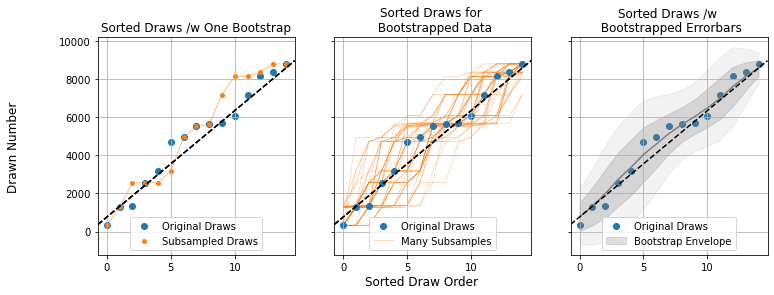

In [4]:
# REDACT
a = nights[5]

#----------------------------------
def BS(a,ntrials=200):
    out = np.zeros([ntrials,a.n], dtype='int32')

    for i in range(ntrials):
        out[i,:] = np.sort(np.random.choice(a.rolls, a.n, replace=True))

    norm = out.mean(axis=0)
    std = out.std(axis=0)
    
    return(np.arange(a.n), norm, std, out)

A, norm, std, wires= BS(a)

#-------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)

np.random.seed(0)
boot = np.sort(np.random.choice(a.rolls,len(a.rolls),replace=True))
ax1.set_title("Sorted Draws /w One Bootstrap")
ax1.scatter(A,np.sort(a.rolls), label = "Original Draws")
ax1.scatter(A,boot, c='tab:orange', s = 15, label = "Subsampled Draws")
ax1.plot(A,boot, alpha=.5, c='tab:orange', lw=1, zorder=-1)
ax1.axline((0,norm.min()), (a.n-1,norm.max()), c='k', ls='--')

ax2.set_title("Sorted Draws for \n Bootstrapped Data")
ax2.scatter(A,np.sort(a.rolls), label = "Original Draws")
label = "Many Subsamples"
for i in range(wires.shape[0]//4):
    ax2.plot(A,wires.T[:,::4][:,i], alpha=.5, c='tab:orange', lw=.5, zorder=-1, label=label)
    label=None
ax2.axline((0,norm.min()), (a.n-1,norm.max()), c='k', ls='--')

ax3.set_title("Sorted Draws /w \n Bootstrapped Errorbars")
ax3.scatter(A,np.sort(a.rolls), label = "Original Draws")
ax3.plot(A,norm, c='tab:grey')
ax3.fill_between(A,norm-std,norm+std,alpha=0.25,color='grey', label = "Bootstrap Envelope")
ax3.fill_between(A,norm-std*2,norm+std*2,alpha=0.1,color='grey')


for ax in (ax1,ax2,ax3):
    ax.legend(loc='lower center')
    ax.axline((0,norm.min()), (a.n-1,norm.max()), c='k', ls='--')
    ax.grid()

fig.supylabel("Drawn Number")
fig.supxlabel("Sorted Draw Order")

plt.show()

## Part 2: Normalizing

Bootstrapping lets us get a rough feel for how unusual our results are, but doesn't take us far down the path of understanding. Ratcheting the complexity up a tiny notch, a good next step is to _normalize_ our ticket draws. We know that each ticket is drawn between some high and low boundary, so we can replace the actual numbers with a measure of where the draws fall within that range:

$$
r = \frac{draw- lower}{upper-lower}
$$

This is basically squashing / stretching the draws from every night into a bracket from $0.0$ to $1.0$, allowing us to properly compare them to one another. The trick of normalizing opens up two possibilities: 
1. We can compare how "clumpy" the draws from each night are on the same graph (Left)
2. We can lump together _all_ of the nights into a big pool to get a feel for how lumpy the results are overall (Right)

From here on out, I've swapped the "sorted list" of draws for the *cumulative distribution function* (CDF), for all intents and purposes the same thing just rotated 90 degrees. The CDF measures what fraction of tickets are drawn _below_ a particular number, i.e. if $CDF(x)=0.5$, that means $50%$ of tickets are $x$ or lower. For a properly uniform distribution, the CDF should be a straight line: half the tickets should fall below $r=0.5$, a quarter below $r=0.25$ and so forth. 


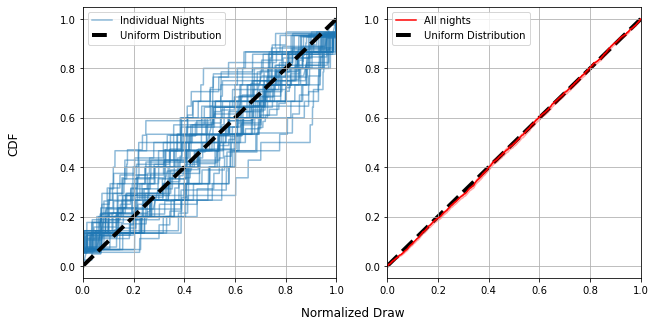

In [5]:
# REDACT
fig, (a1,a2)  = plt.subplots(1,2, figsize=(10,5))

#---------------
# Axis 1
label="Individual Nights"
for a in nights[::4]:
    
    y = np.zeros(a.upper-a.lower+2)
    y[1:] = np.cumsum(np.histogram(a.r, density=True, bins=a.upper-a.lower+1)[0])
    y/=y[-1]
    a1.plot(np.linspace(0,1,a.upper-a.lower+2), y, c='tab:blue', alpha=0.5,label=label, zorder=-10)
    label=None

#---------------
# Axis 2
y = np.zeros(len(all_rolls)+2)
y[1:] = np.cumsum(np.histogram(np.sort(all_rolls), density=True, bins=len(all_rolls)+1)[0])
y/=y[-1]
a2.plot(np.linspace(0,1,len(all_rolls)+2),y,c='r', label="All nights")

# Axis 2 bootstrapping

outs = np.zeros([100,len(y)])

for i in range(outs.shape[0]):
    outs[i,1:] = np.cumsum(np.histogram(np.sort(np.random.choice(all_rolls,len(all_rolls),replace=True)), density=True, bins=len(all_rolls)+1)[0])
    outs[i,:]/=outs[i,-1]
ax2mid = outs.mean(axis=0)
ax2sig = outs.std(axis=0)

a2.fill_between(np.linspace(0,1,len(all_rolls)+2),ax2mid-ax2sig,ax2mid+ax2sig,color='r', alpha=0.25)

#---------------
# Axis format

for a in (a1,a2):
    a.grid()
    a.axline((0,0), slope=1, ls='--',c='k', label = "Uniform Distribution", zorder=-1, lw=4)
    a.set_xlim(0,1)
    a.legend(loc='best')

fig.supxlabel("Normalized Draw")
fig.supylabel("CDF")

plt.show()

Each _individual_ night (blue lines, left) can look pretty far from uniform, with their CDF's spidering out all over the place. This doesn't tell us much more than our bootstrapping approach before: some nights are pretty uniform, others less so, but it does tell us that the ensemble of _all_ nights is not _biased_: The entire set of lines is centered on the straight line of the uniform distribution.

We can also see that, with every draw from every night put together, things are _very_ close to uniform (Right). This tells us that the draws are (in aggregate over all 188 nights) pretty close to uniformly distributed. 

## Part 3 - P Values & The KS Statistic

So far we've seen ways to properly visualize the draws for a given night, along with the "fudge factor" we have to allow for by virtue of coincidence, as well as ways we can combine the data from all nights to get a feel for large-scale patterns. This sort of visual inspection is valuable for identifying anything weird, but there's an important next question in actually interpreting this weirdness:

> _What are the odds of an outcome this strange occurring?_

With this question, we breach the threshold of actual numbers. To answer it, we need to make the leap to some denser statistics. Specifically, we need to introduce two new things: a **[test statistic](https://en.wikipedia.org/wiki/Test_statistic)** and the **[P value](https://en.wikipedia.org/wiki/P-value)**.

In basic terms, a **test statistic** is just some numerical way of quantifying "weirdness". Here, I'm going to use a natural choice: the largest distance the CDF gets from the straight line of a uniform distribution. This has a name: the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) statistic, or "KS Statistic" for short.

In [6]:
# REDACT
KS_actual = np.zeros(len(nights))

for a, i in zip(nights,range(len(nights))):
    if i//(len(nights)%10)==0 and VERBOSE: print("\t %i" %i, end="")
    X = np.arange(a.lower,a.upper+1)
    Ymodel = np.linspace(0,1,len(X))

    y = np.sort(a.rolls)
    y = np.array([np.where(y==x,1,0).sum() for x in X])
    y = np.cumsum(y)
    y= y / y[-1]

    KS_actual[i] = np.max(abs(Ymodel-y))



	 0	 1	 2	 3	 4	 5	 6	 7

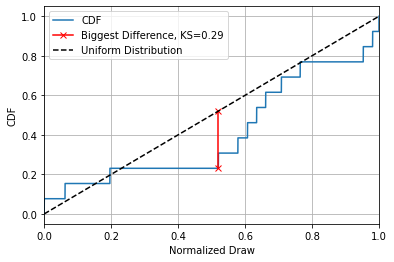

In [7]:
# REDACT
plt.figure()

i_cannon = 23

y = np.zeros(nights[i_cannon].upper-nights[i_cannon].lower+2)
x = np.linspace(0,1,nights[i_cannon].upper-nights[i_cannon].lower+2)
y[1:] = np.cumsum(np.histogram(nights[i_cannon].r, density=True, bins=nights[i_cannon].upper-nights[i_cannon].lower+1)[0])
y/=y[-1]
plt.plot(x, y, c='tab:blue', alpha=1.0,label="CDF")

imax = np.argmax(abs(x-y))
ks = abs(x-y)[imax]
plt.plot((x[imax],x[imax]),(x[imax],y[imax]), c='r', marker = 'x', label = "Biggest Difference, KS=%.2f" %ks)

plt.grid()
plt.axline((0,0), slope=1, ls='--',c='k', label = "Uniform Distribution")
plt.xlim(0,1)

plt.xlabel("Normalized Draw")
plt.ylabel("CDF")
plt.legend(loc="best")


plt.show()

This is far from the only choice we could've made, even for answering our pretty tightly defined question of "how uniform are the draws"? We could have used the average distance between the lines, the total "square difference", some kind of measure involving the bootstrapping interval, or any number of other things. As it happens, the _exact_ choice isn't too important, what's important is turning this into a **P value**, a measure of how likely an outcome this strange is to come about by pure chance.

To get a P value, we use some brute-force simulation:
1. Assuming the draws _are_ uniformly distributed, generate a sample of mock data the same size as our real data
2. Measure the KS statistic of this set
3. Repeat steps 1 and 2 many many times
4. Find whatever fraction of mock-samples have a higher KS statistic than our real data.

Something easy to get mixed up is that a _small_ P value is _more unusual_. I.e. if $P=1.0$, our data is so boring that any simulation is weirder than it, and $P=0.0$ means its so unusual that $100 \%$ of the simulations fail to match is level of strangeness. You can see that the exact test statistic we use to quantify "strangeness" isn't important, what matters is how rarely the simulations manage to meet or beat that amount of strangeness. Usually, we consider anything below $P=0.05$, i.e. a one in twenty chance, to be a good cause for concern.

In [16]:
# REDACT
def ks_sim(n, lower, upper, ntrials=None, bins = 32, debug = True):
    # Brute force generates a set of ks test statistics for frequentist comparison
    if ntrials==None: ntrials=(n*10)**2

    if debug: print("\t doing KS sim with %i rolls" %ntrials)

    X = np.arange(lower,upper+1)
    Ymodel = np.linspace(0,1,len(X))

    sims = np.zeros([ntrials,len(X)])

    for i in range(ntrials):
        if debug and i%(ntrials//10)==0: print("\t %i / %i" %(i, ntrials),end="")
        y = np.random.choice(X, size=n, replace=False)
        y = np.sort(y)

        yout = np.zeros_like(X,dtype='int32')
        for yi in y: yout[np.argwhere(X>=yi)[0][-1]:]+=1
        #y = np.array([np.where(y==x,1,0).sum() for x in X])
        #y = np.cumsum(y)

        yout= yout / yout[-1]
        sims[i,:] = yout

    KS_samples = np.array([abs(a - Ymodel).max() for a in sims])
    return(KS_samples)

#nrolls = int(np.median([a.n for a in nights]))
#nwidth = int(np.median([a.upper-a.lower for a in nights])*1.1)
nrolls = nights[i_cannon].n
nwidth = nights[i_cannon].upper - nights[i_cannon].lower
KS_samples_canonical = ks_sim(nrolls, 0, nwidth , ntrials = 20_000, debug=False)

P_cannon = np.where(KS_samples_canonical>KS_actual[i_cannon],1,0).sum() / len(KS_samples_canonical)
# print("\n\tDone")
# print("For night %i, KS=%.2f for P=%.2f" %(i_cannon,KS_actual[i_cannon],P_cannon))


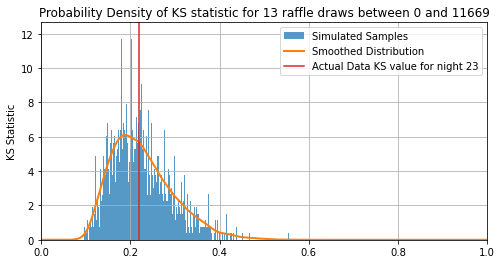

In [9]:
# REDACT
plt.figure(figsize=(8,4))

plt.hist(KS_samples_canonical, density=True, bins = nwidth//3, zorder=-2, alpha=0.75, label="Simulated Samples")
plt.plot(np.linspace(0,1,nwidth//3), gaussian_kde(KS_samples_canonical)(np.linspace(0,1,nwidth//3)), c='tab:orange', lw=2, label="Smoothed Distribution")
plt.axvline(KS_actual[i_cannon], c='tab:red', label="Actual Data KS value for night %i" %i_cannon)
plt.grid()
plt.xlim(0,1)

plt.ylabel("KS-Probability Density")
plt.ylabel("KS Statistic")

plt.title("Probability Density of KS statistic for %i raffle draws between 0 and %i" %(nrolls, nwidth))

plt.legend()

plt.show()

The first thing you'll notice is that $KS=0$ is actually _extremely_ unlikely, with the most likely outcome being some lumpiness with $KS\approx0.2$ This is because there's one and only one way to get a perfectly uniform set of draws but any countless number of ways to get a "slightly non-uniform" result. For this particular night, the KS of the real data is $KS=0.22$, which has $51\%$ of simulations to the right of it. That means its P value is:

$$
P=0.51\approx\frac{1}{2}
$$

I.e. one in two odds for this night, a pretty unremarkable outcome. From here, all we need to do is extend out to all $188$ nights and see if any are _particularly_ unusual.

## Part Four: Putting it Together - How Strange is Strange?


In [10]:
# REDACT
if True:
    Pvalue = np.load("./Pvals.npy")

else:
    Pvalue = np.zeros(len(nights))

    for a, i in zip(nights,range(len(nights))):
        print("\t trial %i: %i rolls between %i and %i" %(i,a.n,a.lower,a.upper), end='\t')
        KS_samples = ks_sim(a.n, a.lower, a.upper, ntrials = 5_000, debug=False)
    
        P = np.sum(np.where(KS_samples>KS_actual[i],1,0)) / len(KS_samples)
    
        print("KS = %f. %i of %i more suspicious. P value = %f" %(KS_actual[i], int(len(KS_samples)*P), len(KS_samples), P))
        
        Pvalue[i]=P

    np.save("./Pvals.npy",Pvalue)

Looking at the P values for all $188$ nights, we see them running the entire range from $P=99.8\%$ to $P=0.35\%$. Some of these P values are pretty severe, one or two have roughly “1 in 300” odds of occurring, but we have to be careful not to raise a false alarm when faced with these outliers. Remember that the P value is only for each _individual_ game: it asks “how unusual is this outcome for _this_ game”. An outcome with 1:100 odds might seem unusual, but not so much if we play well over 100 games.

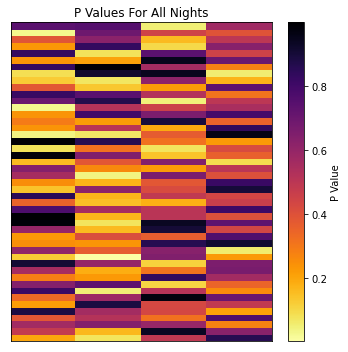

In [11]:
# REDACT
plt.figure(figsize = (5,5))
heatmap = plt.pcolor(np.reshape(Pvalue,[len(Pvalue)//4,4]), cmap='inferno_r')
plt.colorbar(heatmap,label="P Value")

plt.gca().set_xticks([]), plt.gca().set_yticks([])
plt.title("P Values For All Nights")
plt.tight_layout()
plt.show()

Fortunately, the maths to account for this is mercifully simple. Our P values already tell us how strange any given outcome is, and we can multiply them together to get an overall “strangeness” of the entire bank of results. For example, lets look at the strangest night, which has a P value / odds of:

$$
min(P) = 0.35 \% \approx \frac{1}{286}
$$

But remember, this only tells us "What are the odds of getting this result in **one** game", when we've actually got $188$ games to play with. The question we really need to be asking is:

>_How likely is it to play 188 games _without_ getting an outcome this unusual?_

This is simple grade school maths: If there’s a $0.35\%$ chance of something this strange from a given game, we have a $99.65\%$ chance of anything _less_ strange. Now, we can ask "What is the chance of getting this unremarkable of a result 188 times in a row:"

$$
P_{\text{No Strange Games}} = 0.9965 ^ {188} \approx 52 \% \approx \frac{1}{2}
$$

That means, thanks to the sheer number of games we played, there was a roughly 50-50 shot of playing _at least_ one game this strange or more.

# REDACTED

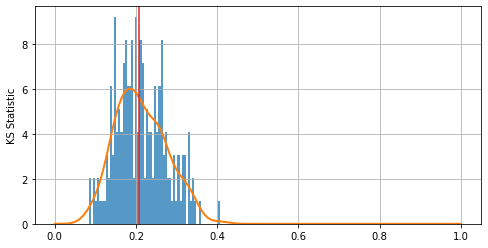

In [12]:
plt.figure(figsize=(8,4))

plt.hist(KS_actual, density=True, bins = len(KS_actual)//3, zorder=-2, alpha=0.75)
plt.plot(np.linspace(0,1,128), gaussian_kde(KS_actual)(np.linspace(0,1,128)), c='tab:orange', lw=2)
plt.axvline(np.median(KS_actual), c='tab:red')
plt.grid()

plt.ylabel("KS-Probability Density")
plt.ylabel("KS Statistic")

plt.show()

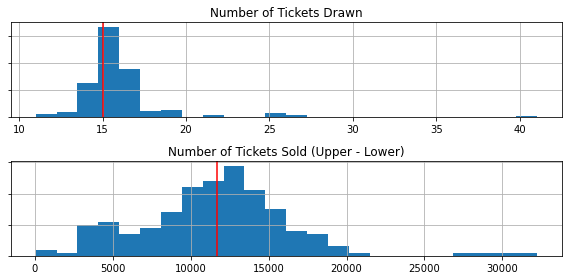

In [13]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,4))

ax1.hist([a.n for a in nights], bins=24)
ax2.hist([a.upper-a.lower for a in nights], bins=24)

ax1.set_yticklabels([]), ax2.set_yticklabels([])

ax1.set_title("Number of Tickets Drawn")
ax2.set_title("Number of Tickets Sold (Upper - Lower)")
ax1.grid()
ax2.grid()

ax1.axvline(15, c='r')
ax2.axvline(nwidth, c='r')

plt.tight_layout()
plt.show()

In [14]:
[(i,Pvalue[i]) for i in np.argsort(Pvalue)[:20]]

[(49, 0.0035),
 (180, 0.027),
 (136, 0.0278),
 (120, 0.0414),
 (97, 0.042),
 (142, 0.0484),
 (29, 0.0522),
 (186, 0.0526),
 (159, 0.0568),
 (55, 0.0592),
 (121, 0.0686),
 (153, 0.0722),
 (69, 0.077),
 (114, 0.077),
 (1, 0.0772),
 (112, 0.0798),
 (169, 0.0804),
 (156, 0.0876),
 (107, 0.0928),
 (174, 0.1006)]

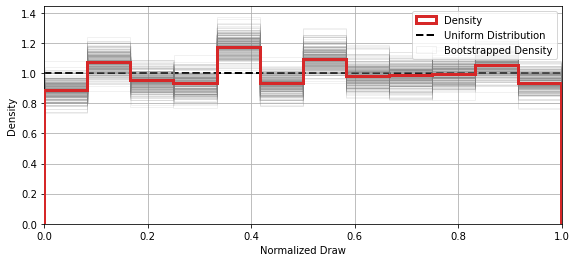

In [15]:
nboots = 256
nbins = 12
binrange = (nbins, nbins+1)

plt.figure(figsize=(8,5*0.75))

# PDF and uniform line
plt.hist(np.sort(all_rolls), bins = nbins, density=True, histtype='step', color='tab:red', lw=3, zorder=100)
plt.axhline(1,c='k',ls='--', lw=2)

# Bootstraps
for i in range(nboots):
    #Y,X = np.histogram(np.sort(np.random.choice(all_rolls,len(all_rolls),replace=True)), bins = np.random.randint(binrange[0],binrange[1]), density=True)
    #plt.plot((X[:-1]+X[1:])/2,Y, c='grey', lw=0.5, alpha=0.1, zorder=-1)
    plt.hist(np.sort(np.random.choice(all_rolls,len(all_rolls),replace=True)), 
             bins = nbins, density=True, histtype='step', 
             color='tab:grey', alpha=0.1, lw=1)

plt.legend(['Density', 'Uniform Distribution', 'Bootstrapped Density'],loc='best')

plt.xlabel("Normalized Draw")
plt.ylabel("Density")
plt.tight_layout()
plt.xlim(0,1)
plt.grid()
plt.show()